# Movie Industry Analysis for Microsoft Movie Studio

![title](images/Movie.jpg)

### Author: <a href="https://www.linkedin.com/in/pcontreras97//">Patricio Contreras</a>

## Overview

The purpose of this project is to help the newly formed Microsoft Movie Studio by performing an analysis of the movie industry and identifying successful genres, possible movie studio partnerships, popular foreign-language films, and most sucessful time of the year to release films.  Microsoft Movie Studio can use the results of this analysis to make data-driven decisions and optimise the production of their future movies.

## Business Problems

The brand new Microsoft Movie Studio is interested in knowing more about the movie industry and start off strong in such a competitive field.  In order to do this, this project will focus on gathering data and analysing the following:

* The most successful movie genres in terms of profit made
* The top 5 movie studios to partner up with by domestic gross box office revenue
* Best non-English languages in terms of film rating
* Best time of the year to release a film by domestic gross box office revenue

## Reading in and Understanding the IMDb, Box Office Mojo, and TMDb Data

The data used in this project was taken from <a href="https://www.boxofficemojo.org/">Box Office Mojo</a>, the Internet Movie Database (<a href="https://www.imdb.com/">IMDb</a>) and The Movie Database (<a href="https://www.themoviedb.org/">TMDb</a>).

In [44]:
# importing necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
# reading in IMDb, Box Office Mojo, and TMDb csvs
df_imdb_title_basics = pd.read_csv("zippedData/imdb.title.basics.csv.gz")
df_bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
df_tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

The IMDb dataset has a unique identifier (`tconst`) for each film, the original and primary title, the year the film was released, movie runtime in minutes, and genres the film falls under.  (For more information on this dataset, please check <a href="https://www.imdb.com/interfaces/">here</a>)

In [46]:
df_imdb_title_basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [47]:
# number of rows, number of columns
df_imdb_title_basics.shape

(146144, 6)

Our dataset from Box Office Mojo has information such as domestic and foreign gross box office revenue and which studio the film came from.

In [48]:
df_bom_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [49]:
df_bom_movie_gross.shape

(3387, 5)

The TMDb dataset has the `production_budget` column which will be key in calculating profit per film in our analysis later:

In [50]:
df_tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [51]:
df_tn_movie_budgets.shape

(5782, 6)

### Check for Duplicates

Some movies were released in different years but are under the same name.  For example, Fantastic Four was released in 2005 and another one in 2015.  **To account for this, we'll say a *unique* film is one that doesn't have a duplicate with the same name and same year**.  To check for duplicate values, we'll search within the title/movie column *and* the year it was released:

In [52]:
# check if the number of duplicates is 0
df_imdb_title_basics.duplicated(subset = ["primary_title", "start_year"]).sum() == 0

False

Unfortunately (as evidenced above), even though the `tconst` column has a unique ID for each film in the IMDb data frame, this does not guarantee there aren't duplicates.

In [53]:
# check if the number of duplicates is 0
df_bom_movie_gross.duplicated(subset = ["title", "year"]).sum() == 0

True

In [54]:
df_tn_movie_budgets.duplicated(subset = ["movie", "release_date"]).sum() == 0

True

--------------------

### Check for Missing Values

Check if there's missing data in the three data frames:

In [55]:
# percentage of missing values per column (IMDb)
df_imdb_title_basics.isna().sum() / len(df_imdb_title_basics)

tconst             0.000000
primary_title      0.000000
original_title     0.000144
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
dtype: float64

In [56]:
# percentage of missing values per column (Box Office Mojo)
df_bom_movie_gross.isna().sum() / len(df_bom_movie_gross)

title             0.000000
studio            0.001476
domestic_gross    0.008267
foreign_gross     0.398583
year              0.000000
dtype: float64

In [57]:
# percentage of missing values per column (TMDb)
df_tn_movie_budgets.isna().sum() / len(df_tn_movie_budgets)

id                   0.0
release_date         0.0
movie                0.0
production_budget    0.0
domestic_gross       0.0
worldwide_gross      0.0
dtype: float64

## Cleaning the IMDb, Box Office Mojo, and TMDb Data Frames

The output shown above tells us there are missing values in the `imdb_title_basics` and `bom_movie_gross` data frames.  Our first two research questions focus on `genres`, `studio`, `production_budget`, and `domestic_gross`.  Given that the percentage of rows with missing data in these columns is minimal (<5%), we can get rid of those rows:

In [58]:
# removing rows with NA in genre column
df_imdb_title_basics.dropna(axis = 0, subset = ["genres"], inplace = True)
# genres column should have no missing data
df_imdb_title_basics.isna().sum() / len(df_imdb_title_basics)

tconst             0.000000
primary_title      0.000000
original_title     0.000014
start_year         0.000000
runtime_minutes    0.202528
genres             0.000000
dtype: float64

In [59]:
# remove rows with NA in studio column
df_bom_movie_gross.dropna(axis = 0, subset = ["studio"], inplace = True)
# studio column should have no missing data
df_bom_movie_gross.isna().sum() / len(df_bom_movie_gross)

title             0.000000
studio            0.000000
domestic_gross    0.007688
foreign_gross     0.398876
year              0.000000
dtype: float64

In [60]:
# remove rows with NA in domestic_gross column
df_bom_movie_gross.dropna(axis = 0, subset = ["domestic_gross"], inplace = True)
# domestic_gross column should have no missing data
df_bom_movie_gross.isna().sum() / len(df_bom_movie_gross)

title             0.000000
studio            0.000000
domestic_gross    0.000000
foreign_gross     0.401967
year              0.000000
dtype: float64

Since we *do* have duplicates in the IMDb data frame, we'll get rid of them:

In [61]:
# filter out IMDb data frame such that it does not include duplicates
df_imdb_title_basics = df_imdb_title_basics[~df_imdb_title_basics.duplicated(subset = ["primary_title", "start_year"])]
# check there are 0 duplicates
df_imdb_title_basics.duplicated(subset = ["primary_title", "start_year"]).sum() == 0

True

Furthermore, keeping two columns in the IMDb data frame with the movie title seems a little redundant.  Since `primary_title` is the most well-known title of a film, we'll keep it and get rid of `original_title`.  We can also get rid of columns such as `tconst`, `runtime_minutes`, `foreign_gross`, and `id` since they won't really be used in our analysis:

In [62]:
# getting rid of unnecessary columns (IMDb)
df_imdb_title_basics.drop(columns = ["tconst", "original_title", 
                                     "runtime_minutes"], axis = 1, 
                          inplace = True)

We'll also get rid of our `domestic_gross` column in the Box Office Mojo data frame since we already have that information (and more of it) in the TMDb data frame:

In [63]:
# getting rid of unnecessary columns (Box Office Mojo)
df_bom_movie_gross.drop(columns = ["domestic_gross", "foreign_gross"], axis = 1,
                       inplace = True)

In [64]:
# getting rid of unnecessary columns (TMDb)
df_tn_movie_budgets.drop(columns = ["id"], axis = 1,
                        inplace = True)

The `production_budget`, `domestic_gross`, and `worldwide_gross` columns in the TMDb data frame aren't in the correct data type.  Let's convert them to integers:

In [65]:
# import custom function from Code folder
from Code import cleanup
# column names of columns I want to change data type
cols = ["production_budget", "domestic_gross", "worldwide_gross"]
for col in cols:
    # iterate thru columns and change the type
    df_tn_movie_budgets[col] = df_tn_movie_budgets[col].apply(cleanup.money_to_int)

The very last cleanup we'll do is rename the columns so they're consistent between data frames.  This way we don't get confused between `start_year`/`year` or `primary_title`/`movie`:

In [66]:
# renaming IMDb columns
df_imdb_title_basics.rename(columns = {"primary_title": "title", 
                                       "start_year": "year"}, inplace = True)
df_imdb_title_basics.head()

,title,year,genres
0,Sunghursh,2013,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,"Biography,Drama"
2,The Other Side of the Wind,2018,Drama
3,Sabse Bada Sukh,2018,"Comedy,Drama"
4,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"


In [67]:
# final dimensions of IMDb table
df_imdb_title_basics.shape

(138926, 3)

In [68]:
df_bom_movie_gross.head()

,title,studio,year
0,Toy Story 3,BV,2010
1,Alice in Wonderland (2010),BV,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,2010
3,Inception,WB,2010
4,Shrek Forever After,P/DW,2010


In [69]:
# final dimensions of Box Office Mojo table
df_bom_movie_gross.shape

(3356, 3)

In [70]:
# renaming TMDb columns
df_tn_movie_budgets.rename(columns = {"movie": "title"}, inplace = True)
df_tn_movie_budgets.head()

,release_date,title,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [71]:
# final dimensions of TMDb table
df_tn_movie_budgets.shape

(5782, 5)

## Merging IMDb and TMDb Data Frames

In order to address our first research question, we'll need to merge the IMDb and TMDb data frames into one.  This way we have the genres and revenue data in one data frame.

Given that a film may appear several times in a data frame but under different years, we'll join both data frames such that the title *and* year match up:

In [72]:
# extract year from release_date
df_tn_movie_budgets["year"] = pd.to_datetime(df_tn_movie_budgets["release_date"]).dt.year
# inner join on title and year
df_imdb_tmdb = df_imdb_title_basics.merge(df_tn_movie_budgets, on = ["title", "year"])
df_imdb_tmdb.head()

,title,year,genres,release_date,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,2012,"Action,Animation,Comedy","Dec 31, 2012",45000000,0,73706
1,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama","Dec 25, 2013",91000000,58236838,187861183
2,A Walk Among the Tombstones,2014,"Action,Crime,Drama","Sep 19, 2014",28000000,26017685,62108587
3,Jurassic World,2015,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864
4,The Rum Diary,2011,"Comedy,Drama","Oct 28, 2011",45000000,13109815,21544732


Our new data frame with all the necessary information has 1,484 rows and 7 columns:

In [73]:
df_imdb_tmdb.shape

(1484, 7)

## Analysis on Domestic Box Office and Movie Genre

The `genres` column in the IMDb data frame has several instances where a film has multiple genres.  For example, Jurassic World has 3 genres (Action, Adventure, and Sci-Fi).  This makes sense, but to make things more simple, we'll only focus on the first two genres since these are the ones people mostly associate a film by:

In [74]:
# function that takes in a genre string and outputs first or second
def genre_separator(genres, num):
    # creates a list with genres
    g_list = genres.split(",")
    if num == 0:
        return g_list[0]
    elif num == 1:
        if len(g_list) > 1:
            return g_list[1]
        else:
            return np.nan

In [75]:
# get a column with only the primary genre
df_imdb_tmdb["primary_genre"] = df_imdb_tmdb["genres"].apply(genre_separator, num = 0)
# extract the secondary genre into its own column
df_imdb_tmdb["secondary_genre"] = df_imdb_tmdb["genres"].apply(genre_separator, num = 1)
df_imdb_tmdb.head()

,title,year,genres,release_date,production_budget,domestic_gross,worldwide_gross,primary_genre,secondary_genre
0,Foodfight!,2012,"Action,Animation,Comedy","Dec 31, 2012",45000000,0,73706,Action,Animation
1,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama","Dec 25, 2013",91000000,58236838,187861183,Adventure,Comedy
2,A Walk Among the Tombstones,2014,"Action,Crime,Drama","Sep 19, 2014",28000000,26017685,62108587,Action,Crime
3,Jurassic World,2015,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,Action,Adventure
4,The Rum Diary,2011,"Comedy,Drama","Oct 28, 2011",45000000,13109815,21544732,Comedy,Drama


We'll compute the profit made by subtracting the `domestic_gross` column by the `production_budget` column:

In [76]:
df_imdb_tmdb["profit"] = df_imdb_tmdb["domestic_gross"] - df_imdb_tmdb["production_budget"]

In [77]:
# grouping by primary AND secondary genre and calculating total profit
df_genres = df_imdb_tmdb.groupby(["primary_genre", "secondary_genre"])[["profit"]].sum()
# sort by total profit and store top 5
df_genres = df_genres.sort_values("profit", ascending = False).head()
df_genres

,,profit
primary_genre,secondary_genre,
Action,Adventure,2978475614
Adventure,Animation,2510846430
Biography,Drama,1497319198
Comedy,Drama,1352991257
Horror,Mystery,1279804898


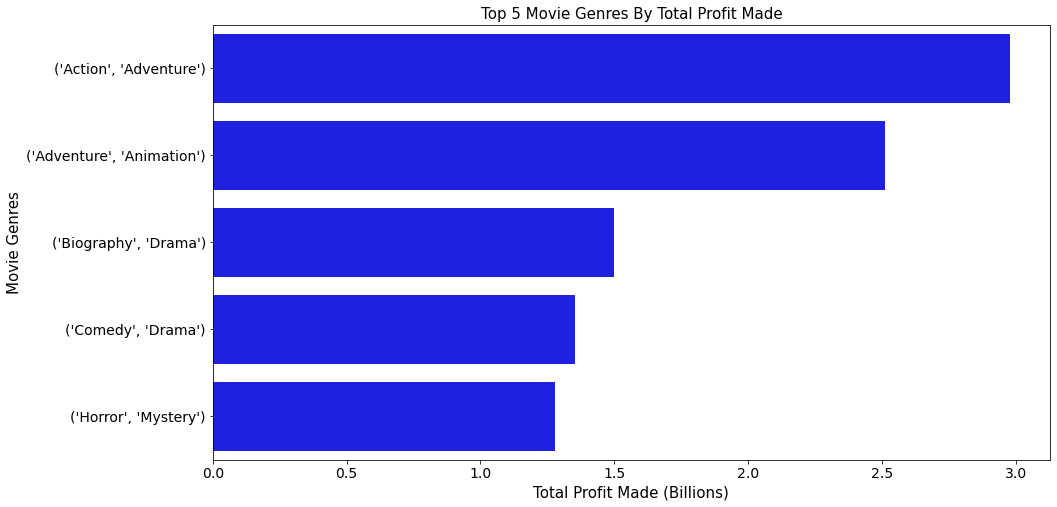

In [90]:
plt.figure(figsize = (15,8))
sns.barplot(x = df_genres["profit"]/1e9, y = df_genres.index,
           color = "b")
plt.title("Top 5 Movie Genres By Total Profit Made", size = 15);
plt.xlabel("Total Profit Made (Billions)", size = 15);
plt.tick_params(labelsize = 14);
plt.ylabel("Movie Genres", size = 15);
plt.savefig("./images/genre_profit.png", dpi = 150, bbox_inches = "tight")

The table and horizontal bar graph above show the top 5 genres by total profit made in billions.  Clearly "Action" and "Adventure" seem to be the most profitable genres as they stand out from the rest.  Another genre to take into account is "Drama" which shows up with "Biography" and "Comedy".  That being said, Microsoft Movie Studio should consider producing films in those genres as they seem to make the studio earn the most "bang for their buck".

## Merging Onto Box Office Mojo Data Frame

We now turn our attention to the Box Office Mojo data frame in order to address our second research question.  Seeing as this is the only data frame that has information on movie studios, we'll join our existing data frame onto it:

In [79]:
# inner join Box Office Mojo data frame on title AND year
df_imdb_tmdb_bom = df_imdb_tmdb.merge(df_bom_movie_gross, on = ["title", "year"])
df_imdb_tmdb_bom.head()

,title,year,genres,release_date,production_budget,domestic_gross,worldwide_gross,primary_genre,secondary_genre,profit,studio
0,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama","Dec 25, 2013",91000000,58236838,187861183,Adventure,Comedy,-32763162,Fox
1,A Walk Among the Tombstones,2014,"Action,Crime,Drama","Sep 19, 2014",28000000,26017685,62108587,Action,Crime,-1982315,Uni.
2,Jurassic World,2015,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,Action,Adventure,437270625,Uni.
3,The Rum Diary,2011,"Comedy,Drama","Oct 28, 2011",45000000,13109815,21544732,Comedy,Drama,-31890185,FD
4,The Three Stooges,2012,"Comedy,Family","Apr 13, 2012",30000000,44338224,54052249,Comedy,Family,14338224,Fox


In [80]:
df_imdb_tmdb_bom.shape

(1026, 11)

## Analysis on Possible Movie Studio Partnership

Having performed our join between the data frames, it's time to look at other movie studios and see how they fare in this competitive industry.  By taking a view at this, the newly formed Microsoft Movie Studio could be inclined to partner up with the best movie studios out there and produce top quality films!

In [81]:
# grouping by studio and computing median domestic_gross
df_studios = df_imdb_tmdb_bom.groupby("studio")[["domestic_gross"]].median()
# renaming column for easier interpretation
df_studios.rename(columns = {"domestic_gross": "Median Domestic Gross"}, 
                 inplace = True)
# sorting values by median domestic gross
df_studios = df_studios.sort_values("Median Domestic Gross", 
                                    ascending = False)
df_top_studios = df_studios.head()
df_top_studios

,Median Domestic Gross
studio,
P/DW,157254783.5
BV,140451743.5
MGM,82992874.0
Sony,78398803.0
Par.,70461045.0


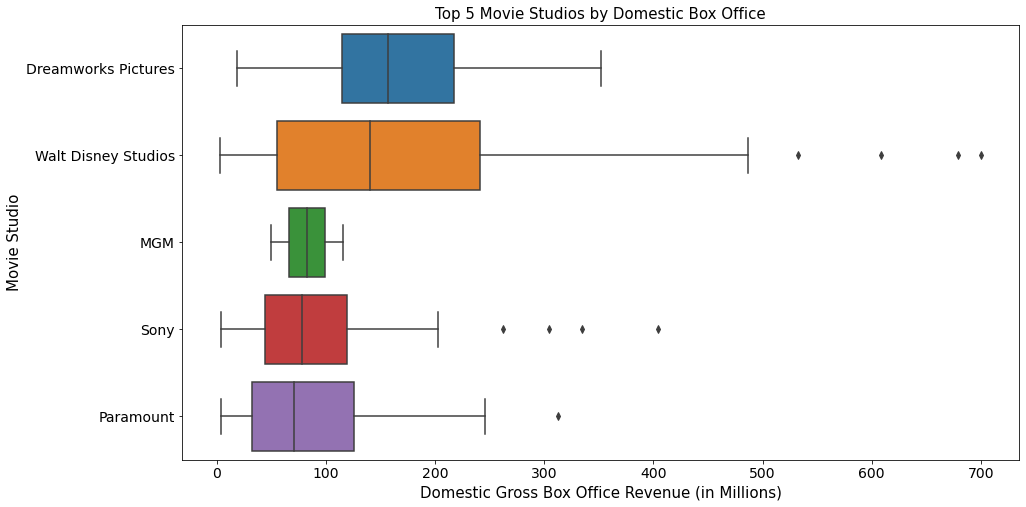

In [89]:
# create a temp data frame from imdb_tmdb_bom that only has the top movie studios
# per median domestic box office
df_top = df_imdb_tmdb_bom[df_imdb_tmdb_bom["studio"].isin(df_top_studios.index)]

plt.figure(figsize = (15,8))
# order boxplots by median
g = sns.boxplot(x = df_top["domestic_gross"]/1e6, y = "studio",
           data = df_top, order = df_top_studios.index)
plt.title("Top 5 Movie Studios by Domestic Box Office", size = 15);
plt.xlabel("Domestic Gross Box Office Revenue (in Millions)", size = 15);
plt.tick_params(labelsize = 14);
plt.ylabel("Movie Studio", size = 15)
g.set_yticklabels(["Dreamworks Pictures", "Walt Disney Studios", 
                   "MGM", "Sony", "Paramount"]);
plt.savefig("./images/studio_gross.png", dpi = 150, bbox_inches = "tight")

The table and horizontal boxplot above show the top 5 movie studios by domestic box office revenue.  The median was used here since the domestic box office revenue distributions are most likely positively skewed for some studios and a statistic such as the average or sum total might not be as accurate or representative.  For example, movies like Avengers Infinity War could seriously pull the average and sum total in Disney's box office revenue distribution to higher values.  Does this mean that Disney's the most successful movie studio on average?  Not really.  Therefore, a more robust statistic is used: the median.  

Both the table and boxplot inform us that Dreamworks and Disney are the movie studios Microsoft should consider when making a film as these have the highest median domestic gross box office revenues.  One thing to note here is Disney's domestic gross box office distribution is way more widespread than its competitors.  Despite the large variance in the Dreamworks and Disney distributions, they stand out from the other movie studios.  

--------

To analyse and dive into the remaining two research questions, please continue onto P2_MovieProject.ipynb!